In [16]:
using JuMP, ECOS, PyPlot

# Solution 1: Moving averages.
Reading the input data and plotting the moving averages initially before actual solving the problem. Reference: Example taken in the class and on the slides.

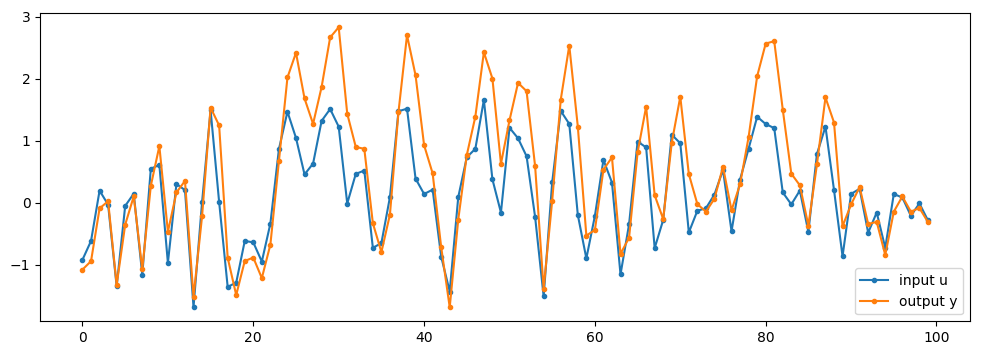

In [17]:
# Load the data file (ref: Boyd/263)
raw = readcsv("/Users/spidy/Documents/CS524/uy_data.csv");
u = raw[:,1];
y = raw[:,2];
T = length(u)

# plot the u and y data
figure(figsize=(12,4))
plot([u y],".-");
legend(["input u", "output y"], loc="lower right");

<b><u>Solution 1a: </u></b> Using the same dataset from class uy_data.csv, plot the true y, and on the same axes, also plot the estimated ˆy using the MA model and the estimated ˆy using the AR model. Use k = 5 for both models. To quantify the difference between estimates, also compute ||y − yˆ|| for both cases.

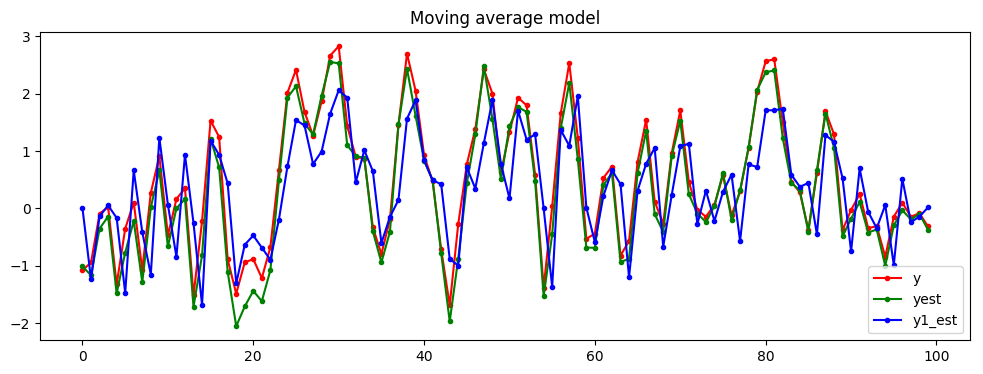


Error - MA: 2.460854388269911
Error - AR: 7.436691765656793


In [18]:
# generate A matrix. Using more width creates better fit.  (MA model)
width = 5
A = zeros(T,width)

for i = 1:width
    A[i:end,i] = u[1:end-i+1]
end

wopt = A\y
yest = A*wopt

# generate A1 matrix. Using more width creates better fit.  (AR model)
A1 = zeros(T, width)
for i = 1:width
    A1[i+1:end,i] = y[1:end-i]
end

a1opt = A1\y
y1_est = A1*a1opt


figure(figsize=(12,4))
plot(y,"r.-",yest,"g.-",y1_est,"b.-")
legend(["y", "yest", "y1_est"], loc="lower right");
title("Moving average model");
println()
println("Error - MA: ", norm(yest-y))
println("Error - AR: ", norm(y1_est-y))

<b><u>Solution 1b: </u></b> Yet another possible modeling choice is to combine both AR and MA. Unsurprisingly, this is
called the autoregressive moving average (ARMA) model: 
ARMA: yt ≈ a1yt−1 + a2yt−2 + · · · + alyt− + b1ut + b2ut−1 + · · · + bkut−k+1. Solve the problem once more, this time using an ARMA model with k=l=1. Plot y and ˆy as before, and also compute the error ||y − yˆ||.

getvalue(a) :0.4852141178557693
getvalue(b) :1.084442141631003
getvalue(t) :1.8565828133664306


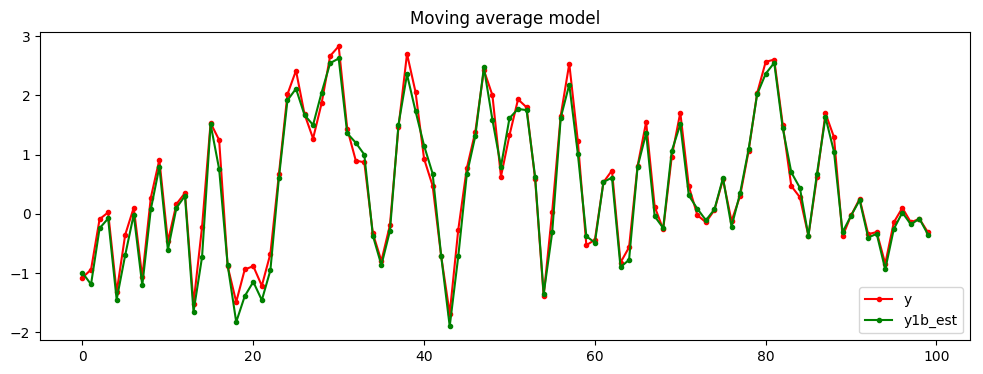


Error - ARMA: 1.8565828148734604


In [19]:
ma = u
ar = zeros(T)

ar[2:end] = y[1:end-1]
m1b = Model(solver=ECOSSolver(verbose=0))
@variable(m1b, a)
@variable(m1b, b)
@variable(m1b, t)
@constraint(m1b, norm(y - (ma*b + ar*a)) <= t)
@objective(m1b, Min, t)
solve(m1b)

println("getvalue(a) :", getvalue(a))
println("getvalue(b) :", getvalue(b))
println("getvalue(t) :", getvalue(t))
y1b_est = (getvalue(b) * ma) + (getvalue(a) * ar)

figure(figsize=(12,4))
plot(y,"r.-",y1b_est,"g.-")
legend(["y", "y1b_est"], loc="lower right");
title("Moving average model");
println()
println("Error - ARMA: ", norm(y1b_est-y))

# Solution 2: Voltage smoothing.
When R(v) is smaller, the voltage is smoother. Solve a regularized least squares problem that explores the tradeoff between matching the desired signal above and making the signal smooth. Explain your reasoning, and include a plot comparing the desired voltages with your smoothed voltages.

Given: characterize smoothness is via the sum of squared differences:
\begin{equation*}
R(v) = (v_2 − v_1)^2 + (v_3 − v_2)^2 + · · · + (v_{200} − v_{199})^2
\end{equation*}

Error norm can be calculated as the norm J1
\begin{equation*}
\sum_{i=1}^T (x_i - inputvoltage_{i-1})^2
\end{equation*}

Smoothness will be nothing but say J2
\begin{equation*}
\sum_{i=2}^T (x_i - x_{i-1})^2
\end{equation*}

We would like to make both J1 and J2 small. 
\begin{equation*}
minimize_x:  J1 + λJ2
\end{equation*}

where λ > 0 is a (fixed) tradeoff parameter.

In [5]:
using Gurobi
voltage = readcsv("/Users/spidy/Documents/CS524/voltages.csv")
T = length(voltage)
println(T)

function solution2(λ)
    m2 = Model(solver=GurobiSolver(OutputFlag=0))

    # Voltage variable 1 ... 20: x1, x2, ...., x200
    @variable(m2, x[1:T])
    # Given: characterize smoothness is via the sum of squared differences:
    # R(v) = (v2 − v1)^2 + (v3 − v2)^2 + · · · + (v200 − v199)^2
    # (sum((x[i] - x[i-1])^2 for i in 2:T)

    # Error norm will be nothing but the difference between desired voltage signal x1, x2, ... x200 and given input voltage
    # signal.
    # sum((x[i] - voltage[i])^2 for i in 1:T)

    # since we need to solve a regularized least squares problem that explores the tradeoff between matching the 
    # desired signal above and making the signal smooth.

    @objective(m2, Min, λ*(sum((x[i] - x[i-1])^2 for i in 2:T)) + sum((x[i] - voltage[i])^2 for i in 1:T))
    solve(m2)
    vol_opt_val = getvalue(x)
    return vol_opt_val
end
                        
sol2 = [solution2(lambda) for lambda in logspace(-4, 5, 6)];

200


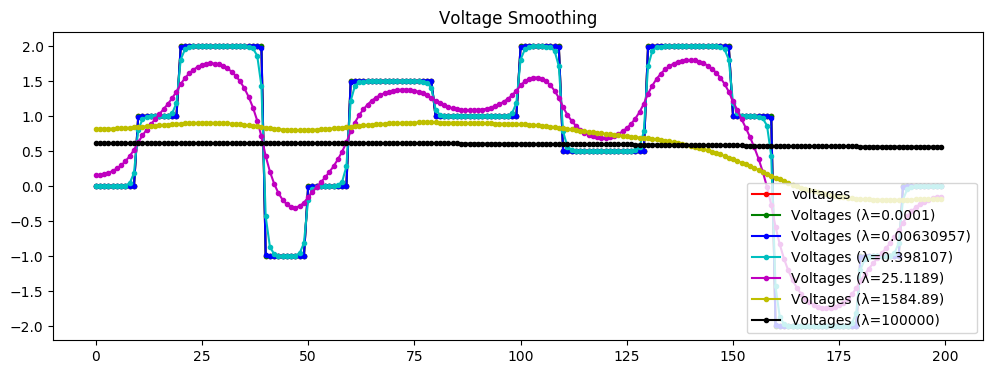

In [6]:
figure(figsize=(12,4))
plot(voltage,"r.-",sol2[1],"g.-",sol2[2],"b.-",sol2[3],"c.-",sol2[4],"m.-",sol2[5],"y.-",sol2[6],"k.-")
legend(["voltages", "Voltages (λ=0.0001)","Voltages (λ=0.00630957)","Voltages (λ=0.398107)","Voltages (λ=25.1189)","Voltages (λ=1584.89)","Voltages (λ=100000)"], loc="lower right");
title("Voltage Smoothing");
println()

<b><u>Explanation:</u></b> I took lambda values to be in the logspace (-4, 5) and took minimum values for 6 different values. Please find them plotted in the graph above. As we can see from the graph is that the value of λ is smaller, then more weight is given to the error norm and so less to smoothening factor. As slowly when we increase the value of λ the weightage of smoothness becomes more prominent and for λ = 100000 we see graph (black plotting) which conveys high smoothness factor.

# Solution 3
We are running a series of experiments to evaluate the properties of a new fluorescent material. As we vary the intensity of the incident light, the material should fluoresce different amounts. Unfortunately, the material isn’t perfectly uniform and our method for measuring fluorescence is not very accurate. After testing 200 different intensities, we obtained the result below (also available in xy_data.csv). The intensities xi and fluorescences yi are recorded in the first and second columns of the data matrix, respectively.

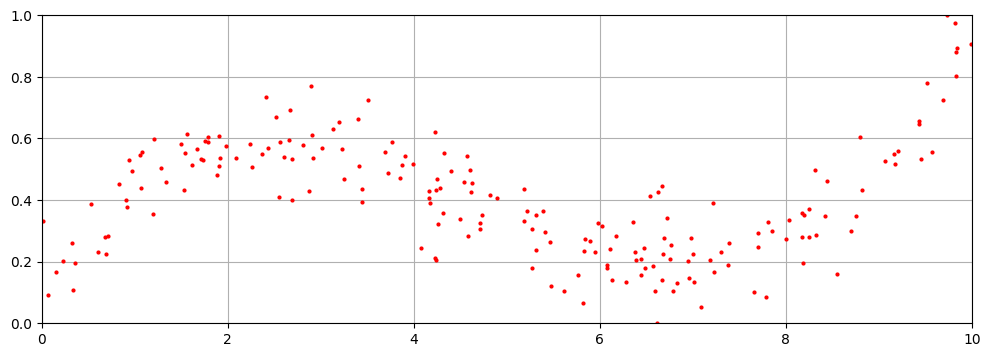

In [7]:
# define (x,y) coordinates of the points
data = readcsv("/Users/spidy/Documents/CS524/xy_data.csv");
x = data[:,1];
y = data[:,2];

using PyPlot
figure(figsize=(12,4))
plot(x,y,"r.", markersize=4)
xlim([0,10]); ylim([0.0,1.0])
grid("on")

<b><u>Solution 3a:</u></b> Polynomial fit. Find the best cubic polynomial fit to the data. In other words, look for a
function of the form y = a1x3 + a2x2 + a3x + a4 that has the best possible agreement with the data. Remember that the model should have zero fluorescence when the intensity is zero! Include a plot of the data along with your best-fit cubic on the same axes.

In [8]:
# order of polynomial to use
k = 3

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [9]:
m3 = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m3, u[1:k+1])
@constraint(m3, u[4] == 0)
@objective(m3, Min, sum( (y - A*u).^2 ) )
status = solve(m3)
uopt = getvalue(u)
println(status)
println("Value of u: ", getvalue(u))

Optimal
Value of u: [0.00932501,-0.134546,0.511155,-0.0]


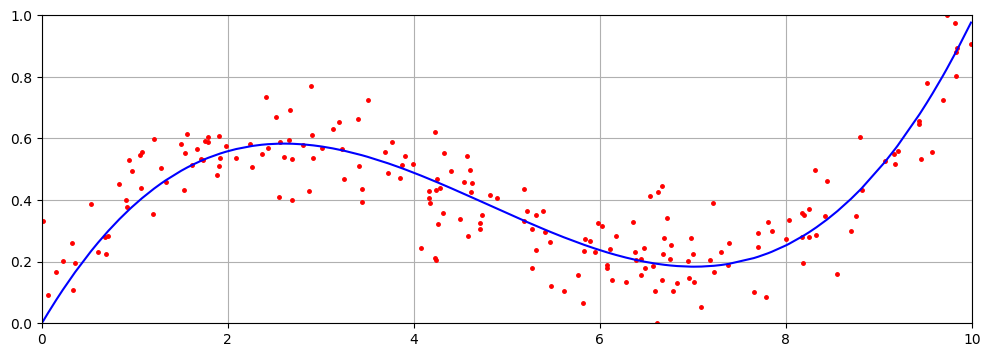

In [10]:
npts = 200
xfine = x
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(12,4))
plot( x, y, "r.", markersize=5)
plot( xfine, yfine, "b-")
xlim([0,10]); ylim([0.0,1.0]); grid()

<b><u>Solution 3b: </u></b> Spline fit. Instead of using a single cubic polynomial, we will look for a fit to the data using two quadratic polynomials. Specifically, we want to find coefficients pi and qi so that our data is well modeled by the piecewise quadratic function:
\begin{equation*}
y = p_1x^2 + p_2x + p_3 
\end{equation*}
\begin{equation*}
y = q_1x^2 + q_2^x + q3
\end{equation*}

These quadratic functions must be designed so that:
<li>as in the cubic model, there is zero fluorescence when the intensity is zero.</li>
<li>both quadratic pieces have the same value at x = 4.</li>
<li> both quadratic pieces have the same slope at x = 4.</li>
In other words, we are looking for a smooth piecewise quadratic. This is also known as a spline
(this is just one type of spline, there are many other types!). Include a plot of the data along with
your best-fit model.

In [11]:
# order of polynomial to use
k = 2

# Selecting only the coordinates of x which are < 4 for the first quadratic equation. All the values of x in the input
# are > 0 and < 10
newxp = [x[i] for i in 1:200 if x[i] < 4]
# Selecting corresponding y values for x < 4
newyp = [y[i] for i in 1:200 if x[i] < 4]

# Selecting only the coordinates of x which are >= 4 for the first quadratic equation. All the values of x in the input
# are > 0 and < 10
newxq = [x[i] for i in 1:200 if x[i] >= 4]
newyq = [y[i] for i in 1:200 if x[i] >= 4]

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

n = length(newxp)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = newxp[i]^(k+1-j)
    end
end

n = length(newxq)
B = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        B[i,j] = newxq[i]^(k+1-j)
    end
end

In [12]:
m3b = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m3b, p[1:k+1])
@variable(m3b, q[1:k+1])
# 1st constraint
@constraint(m3b, p[3] == 0)
# @constraint(m3b, q[3] == 0)

# 2nd constraint
@constraint(m3b, 16*p[1] + 4*p[2] + p[3] == 16*q[1] + 4*q[2] + q[3])
# 3rd constraint
@constraint(m3b, 8*p[1] + p[2] == 8*q[1] + q[2])
@objective(m3b, Min, sum( (newyp - A*p).^2 ) + sum( (newyq - B*q).^2 ))
status = solve(m3b)
println(status)
println("Values of p: ", getvalue(p))
println("Values of q: ", getvalue(q))

Optimal
Values of p: [-0.0873261,0.467682,-0.0]
Values of q: [0.0484683,-0.618673,2.17271]


In [13]:
Yp = A * getvalue(p)
Yq = B * getvalue(q);

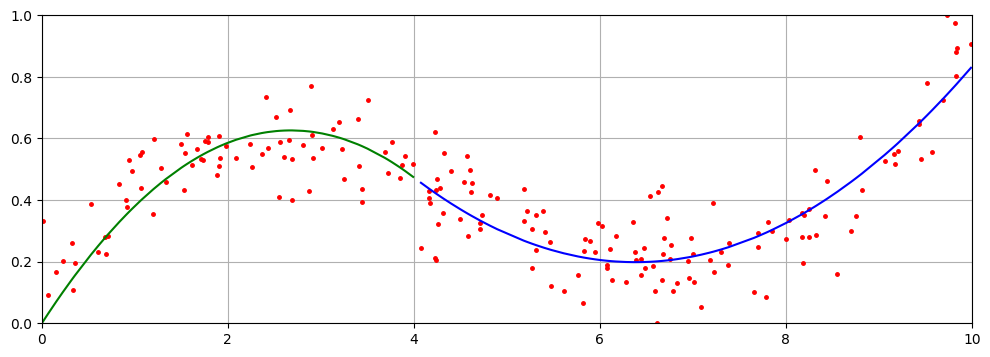

In [14]:
# yfine = ffine * getvalue(p)
figure(figsize=(12,4))
plot( x, y, "r.", markersize=5)
plot( newxp, Yp, "g-")
plot( newxq, Yq, "b-")
xlim([0,10]); ylim([0.0,1.0]); grid()

<b><u>Explanation: </u></b> We can see from the above plotting that green line is for the first quadratic equation whereas the blue line is for second quadratic equation. We apply the pi values to the first one where x < 4 and qi values to coordinates where x >= 4.
<br>
<b>Note</b> I am not sure why I was getting same value on putting constraint "constraint(m3b, q[3] == 0)" for both p and q and something was not making sense and hence I removed that constrainst. Anyways it wasn't making sense as for the second quadratic equation we are only considering values of x >=4.